# LIDC-IDRI Lung Segmentation


In [1]:
import cv2
import keras
import datasets
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from dataclasses import dataclass

from models.unet import UNet

/Users/jmanuelc87/Documents/Proyectos/lung-segmentation-lidc-idri/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Load the dataset


In [2]:
lung_dataset = datasets.load_dataset("jmanuelc87/lidc-idri-segmentation")
lung_dataset = lung_dataset["train"].train_test_split(train_size=0.8, seed=42)  # type: ignore
lung_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 2120
    })
    test: Dataset({
        features: ['image', 'image_mask', 'patch', 'patch_mask', 'malignancy', 'cancer'],
        num_rows: 531
    })
})

## Configuration


In [3]:
@dataclass
class TrainingConfig:
    EPOCHS: int = 3
    NUM_CLASSES: int = 1
    BATCH_SIZE: int = 32
    IMG_WIDTH: int = 512
    IMG_HEIGHT: int = 512

## Visualization

Exploration of some samples of the dataset and its masks


In [4]:
def num_to_rgb(mask):
    num_arr = np.array(mask)
    output = np.zeros(num_arr.shape[:2] + (3,))
    output[num_arr == 255] = (255, 0, 0)
    return output.astype(np.uint8)

In [5]:
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

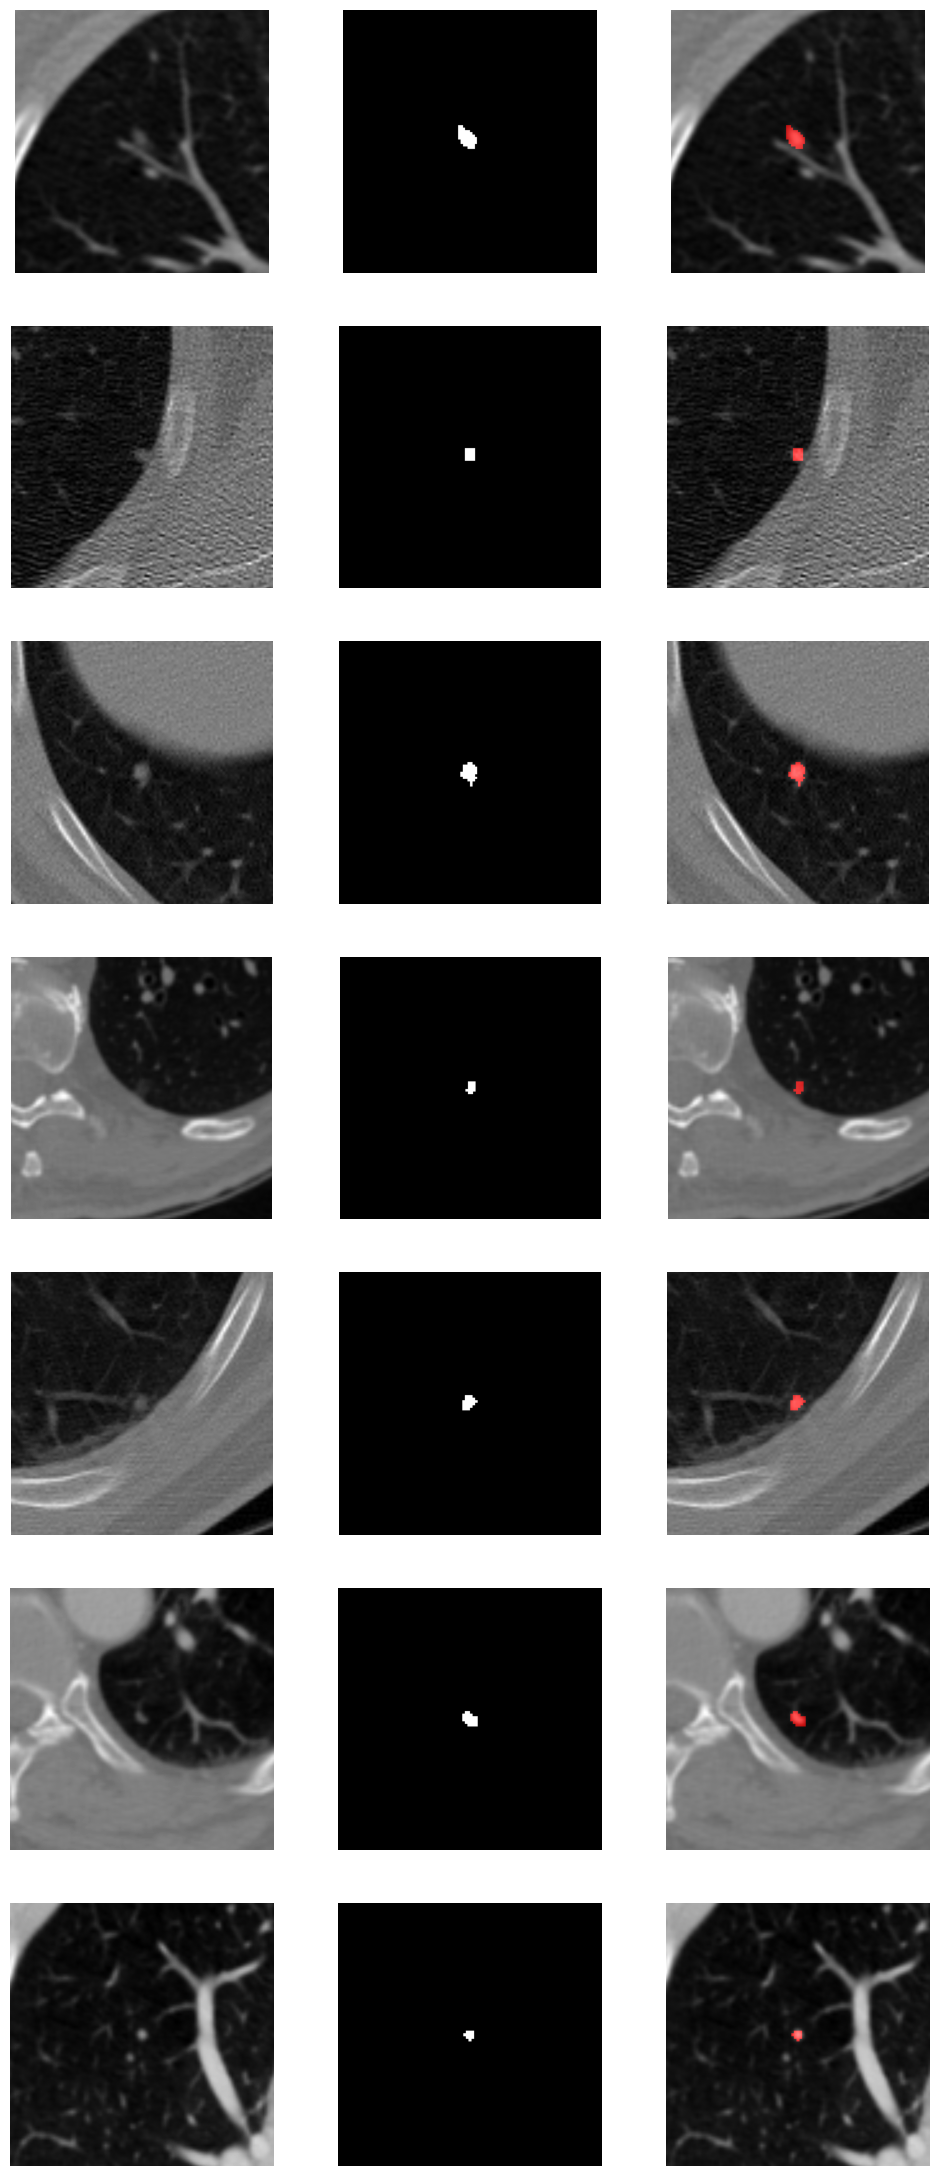

In [6]:
def plot(dataset: datasets.Dataset, qty=10):
    fig, ax = plt.subplots(qty, 3, figsize=(12, 28))

    for i, item in enumerate(dataset):
        if i >= qty:
            break

        ax[i, 0].axis("off")
        ax[i, 0].imshow(item["patch"], cmap="gray")  # type: ignore

        ax[i, 1].axis("off")
        ax[i, 1].imshow(item["patch_mask"], cmap="gray")  # type: ignore

        patch = np.array(item["patch"])  # type: ignore
        patch = np.transpose(np.stack([patch, patch, patch]), axes=(1, 2, 0))

        mask = num_to_rgb(item["patch_mask"])  # type: ignore
        image = image_overlay(patch, mask)

        ax[i, 2].axis("off")
        ax[i, 2].imshow(image, cmap="gray")


plot(lung_dataset["train"], qty=7)  # type: ignore

## Data Preparation

Preparation of the dataset using albumentations library for augmenting the dataset samples using the transformations:

- RandomCrop
- CenterCrop
- SquareSymmetry
- GaussNoise
- Normalize
- ToTensor

And creation of the train, valid and test splits for datasets and dataloaders


In [7]:
train_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            interpolation=cv2.INTER_NEAREST,
            p=1.0,
        ),
        A.SquareSymmetry(p=0.4),
        A.GaussNoise(std_range=(0.1, 0.2), p=0.15),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)


valid_transforms = A.Compose(
    [
        A.Resize(
            height=TrainingConfig.IMG_HEIGHT,
            width=TrainingConfig.IMG_WIDTH,
            p=1.0,
        ),
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0,
            p=1.0,
        ),
    ]
)

In [8]:
def map_image_transforms(transformations):

    def wrapper(row):
        augmented = []
        keys = row.keys()
        for item in zip(*row.values()):
            items = {k: np.array(v) for k, v in zip(keys, item)}
            values = transformations(**items)
            augmented.append(values)

        for key in keys:
            row[key] = [np.expand_dims(item[key], axis=-1) for item in augmented]

        return row

    return wrapper

In [9]:
# Remove the columns not needed and rename the ones needed to be interpreted by albumentations library
new_lung_dataset = (
    lung_dataset.remove_columns(["image", "image_mask", "malignancy", "cancer"])
    .rename_column("patch", "image")
    .rename_column("patch_mask", "mask")
)

In [10]:
def create_datasets(lung_dataset):
    lung_train_dataset = (
        lung_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(train_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    tmp_dataset = lung_dataset["test"].train_test_split(train_size=0.5)

    lung_valid_dataset = (
        tmp_dataset["train"]
        .with_format("tensorflow")
        .with_transform(map_image_transforms(valid_transforms))
        .to_tf_dataset(
            columns="image",
            label_cols="mask",
            batch_size=TrainingConfig.BATCH_SIZE,
        )
    )

    lung_test_dataset = (
        tmp_dataset["test"]
        .with_format("tf")
        .with_transform(map_image_transforms(valid_transforms))
    )

    return lung_train_dataset, lung_valid_dataset, lung_test_dataset

In [11]:
(
    train_dataset,
    valid_dataset,
    test_dataset,
) = create_datasets(new_lung_dataset)

2025-08-31 12:47:02.615694: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-08-31 12:47:02.615725: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-08-31 12:47:02.615732: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-08-31 12:47:02.615749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-31 12:47:02.615757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Modeling

Creation of a UNet model in pytorch


In [12]:
def dice_per_class(y_true, y_pred):
    axes = (0, 1, 2)

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    inter = tf.reduce_sum(y_true * y_pred, axis=axes)
    denom = tf.reduce_sum(y_true + y_pred, axis=axes)
    dice = tf.math.divide_no_nan(2.0 * inter, denom)
    return dice


def dice(y_true, y_pred):

    DICE = tf.reduce_mean(dice_per_class(y_true, y_pred))

    return DICE


def dice_loss(y_true, y_pred):

    DICE = 1.0 - tf.reduce_mean(dice_per_class(y_true, y_pred))

    CCE = keras.losses.binary_focal_crossentropy(y_true, y_pred)

    return DICE + CCE

In [13]:
model = UNet(num_classes=TrainingConfig.NUM_CLASSES)

cosine_decay = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=1000
)


model.compile(
    loss=dice_loss,
    optimizer=keras.optimizers.Adam(learning_rate=cosine_decay),  # type: ignore
    metrics=["accuracy", dice],
)

In [ ]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=TrainingConfig.EPOCHS,
    verbose="1",
)

Epoch 1/3


2025-08-31 12:47:04.808946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
